In [1947]:

%autoreload 2

In [1948]:
import boto3
import lambda_function_v2
import cv2
import utils
import matplotlib.pyplot as plot
import color_images as ci
import numpy as np

In [1949]:
abalone_template_contour, small_abalone_template_contour, quarter_template_contour = lambda_function_v2.get_template_contours(rescaled_image)

In [1950]:
is_deployed = False

In [1951]:
imageName = "blue_bkground_data/2016-08-01 17_44_32.1A.jpg"
#imageName = "color_bkground_data/IMG_5709.JPG"
#imageName = "may_2017_data/IMG_7.01.JPG"
#imageName = "617_data/FrankPhotos/Glass_Beach_Memorial_Day_ - 1003_214.jpg"
#imageName = "new_color_bkground_data/blue/Eric 12.jpg"
showResults=True

In [1952]:
image_full = cv2.imread(imageName, cv2.IMREAD_COLOR)
rescaled_image, scaled_rows, scaled_cols = lambda_function_v2.get_scaled_image(image_full)
#read the image
orig_cols = len(image_full[0]) 
orig_rows = len(image_full)

#if its vertical, flip it 90
if orig_cols < orig_rows:
    img = cv2.transpose(image_full)  
    img = cv2.flip(img, 0)
    image_full = img.copy()
    orig_cols = len(image_full[0])
    orig_rows = len(image_full)
    

In [1953]:
mean_color = utils.get_mean_background_color(image_full)

is_white_or_gray = mean_color[1] < 70
print("is it white or gray: {}".format(is_white_or_gray))

is it white or gray: False


H:167.0, S:120.0, V:57.5
H:103.0, S:168.5, V:167.0


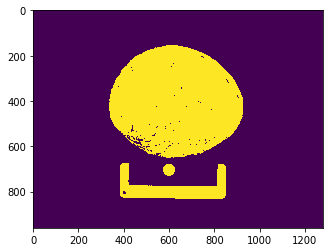

In [1954]:
#is_color_bkground = utils.is_color(rescaled_image)
#background_val_diff = utils.is_background_similar_color(rescaled_image)
quarter_width = 0.955

#all the work
thresh_val = 30
blur_window = 5
contour_color=(0,0,255)
is_ruler=False
use_gray_threshold=False
enclosing_contour=None
first_pass=False
is_small=False
use_adaptive=False
input_image = rescaled_image.copy()
color_image, threshold_bw, color_img, mid_row = ci.get_image_with_color_mask(input_image, thresh_val, 
    blur_window, False, first_pass, is_ruler, use_adaptive)
plot.imshow(threshold_bw)

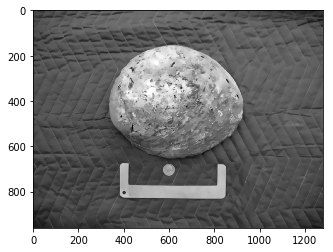

In [1955]:
copied = input_image.copy()
denoised = cv2.fastNlMeansDenoisingColored(copied,None,10,10,7,21)

gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5),0)
plot.imshow(blur, cmap='gray')

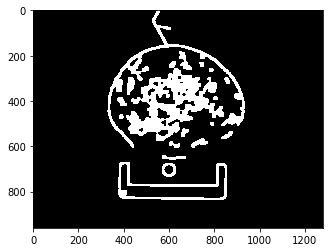

In [1956]:

if is_white_or_gray:
    lower_bound = 100
else:
    lower_bound = 20
    
edged_img = cv2.Canny(blur, lower_bound, 250,7) 

dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
kernel = np.ones((3,3), np.uint8)

edged_img = cv2.dilate(edged_img, kernel, iterations=4)
edged_img = cv2.morphologyEx(edged_img, cv2.MORPH_CLOSE, dilate_kernel)


#check this - seems like dark on white needs a cleanup, color needs an thickening
if is_white_or_gray:
    edged_img = cv2.erode(edged_img, erode_kernel, iterations=1)
else:
    
    edged_img = cv2.dilate(edged_img, kernel, iterations=1)
    
#do this if edges are continuos and huge
#erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
#edged_img = cv2.morphologyEx(edged_img, cv2.MORPH_OPEN, erode_kernel)
#edged_img = cv2.erode(edged_img, erode_kernel, iterations=3)
#

plot.imshow(edged_img, cmap='gray')

328, 0, 606, 607
1280, 960


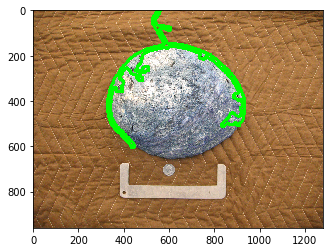

In [1957]:
#gray_denoised = cv2.cvtColor(edged_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(edged_img.copy(), 127,255,0)
cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
len(cnts)
largest = utils.get_largest_edges(cnts[1])
len(largest)

ncols = len(rescaled_image[0]) 
nrows = len(rescaled_image)
img_area = nrows*ncols
img_area

matches = []
cnt = 0

for contour in largest:
    perc = contour[0]/img_area
    
    if perc <= 0.75:
        x,y,w,h = cv2.boundingRect(contour[1])
        print("{}, {}, {}, {}".format(x,y,w,h))
        print("{}, {}".format(ncols, nrows))
        if w > 0.9*ncols or h > 0.9*nrows:
            continue
        target_contour = contour[1]
        break

    else:
        print("skipping a contour...")
        

contours = np.array(target_contour)
output = rescaled_image.copy()

cv2.drawContours(output, contours,-1, (0,255,0),13)
plot.imshow(output)

num contours for quaerter: 3
num in np: 347


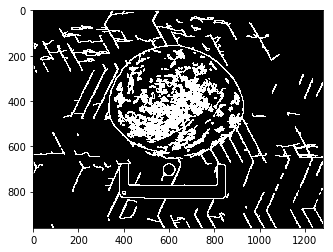

In [1958]:
#get the quarter
if is_white_or_gray:
    lower_bound = 100
else:
    lower_bound = 20
    
scale_img = cv2.Canny(gray, lower_bound, 250,7) 
kernel = np.ones((3,3), np.uint8)

scale_img = cv2.dilate(scale_img, kernel, iterations=2)


ret, thresh = cv2.threshold(scale_img.copy(), 127,255,0)
scale_cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print("num contours for quaerter: {}".format(len(scale_cnts)))
scale_contours = np.array(scale_cnts[1])
print("num in np: {}".format(len(scale_contours)))
cv2.drawContours(drawing, scale_contours,-1, (0,255,0),13)
plot.imshow(scale_img, cmap="gray")


val: 0.00039315757875524326
val: 0.7070993753565988
val: 0.7717239088372174


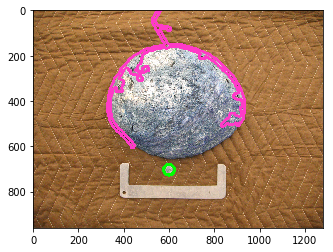

In [1959]:


ncols = len(rescaled_image[0]) 
nrows = len(rescaled_image)
img_area = nrows*ncols
img_area

target_perc = 40*40/img_area
matches = []
cnt = 0

for scontour in scale_contours:
    try:
        carea = cv2.contourArea(scontour)
        perc = carea/img_area
        

        if perc <= 0.15 and perc >= target_perc:
            if utils.is_really_round(scontour):
                if not utils.is_contour_enclosed(scontour, target_contour, True):
                    matches.append(scontour)
    except Exception:
        continue

minVal=1000000
dex = 0
for i, match in enumerate(matches):
    val = cv2.matchShapes(match, quarter_template_contour, 2, 0.0)
    print("val: {}".format(val))
    if val < minVal:
        dex = i
        minVal = val
    
thinned = np.array(matches[dex])
new_drawing = rescaled_image.copy()
cv2.drawContours(new_drawing, thinned,-1, (0,255,0),13)
cv2.drawContours(new_drawing,[target_contour],-1,(255,59,200),12)
plot.imshow(new_drawing)
